In [1]:
from ganrec_dataloader import * 
from utils import *   
from models import *
from setup import *
from visualize import *
from skimage.transform import resize
import time
import joblib
from joblib import Parallel, delayed

In [6]:
import quantities as pq
simulation = load_images_parallel(['/beegfs/desy/user/jentscht/for_dawit/groundtruth/mg10gd_screw_60000_eV/ground_truth_projection/ground_truth_projection_attenuation_60000_eV_00000_type_float32_16384x16384.tif', '/beegfs/desy/user/jentscht/for_dawit/groundtruth/mg10gd_screw_60000_eV/ground_truth_projection/ground_truth_projection_phase_60000_eV_00000_type_float32_16384x16384.tif'])
phase_image_resized, attenuation_image_resized = fun_images_parallel(simulation, 'resize', (256, 256))


energy:  60 keV z:  19.8219 m fresnel_number:  0.01 dimensionless pv:  2.023858749373828e-06 m lam:  2.0664034413537527e-11 m
energy:  60 z:  19.8219 fresnel_number:  0.01 pv:  2.023858749373828e-06 lam:  2.0664034413537527e-11


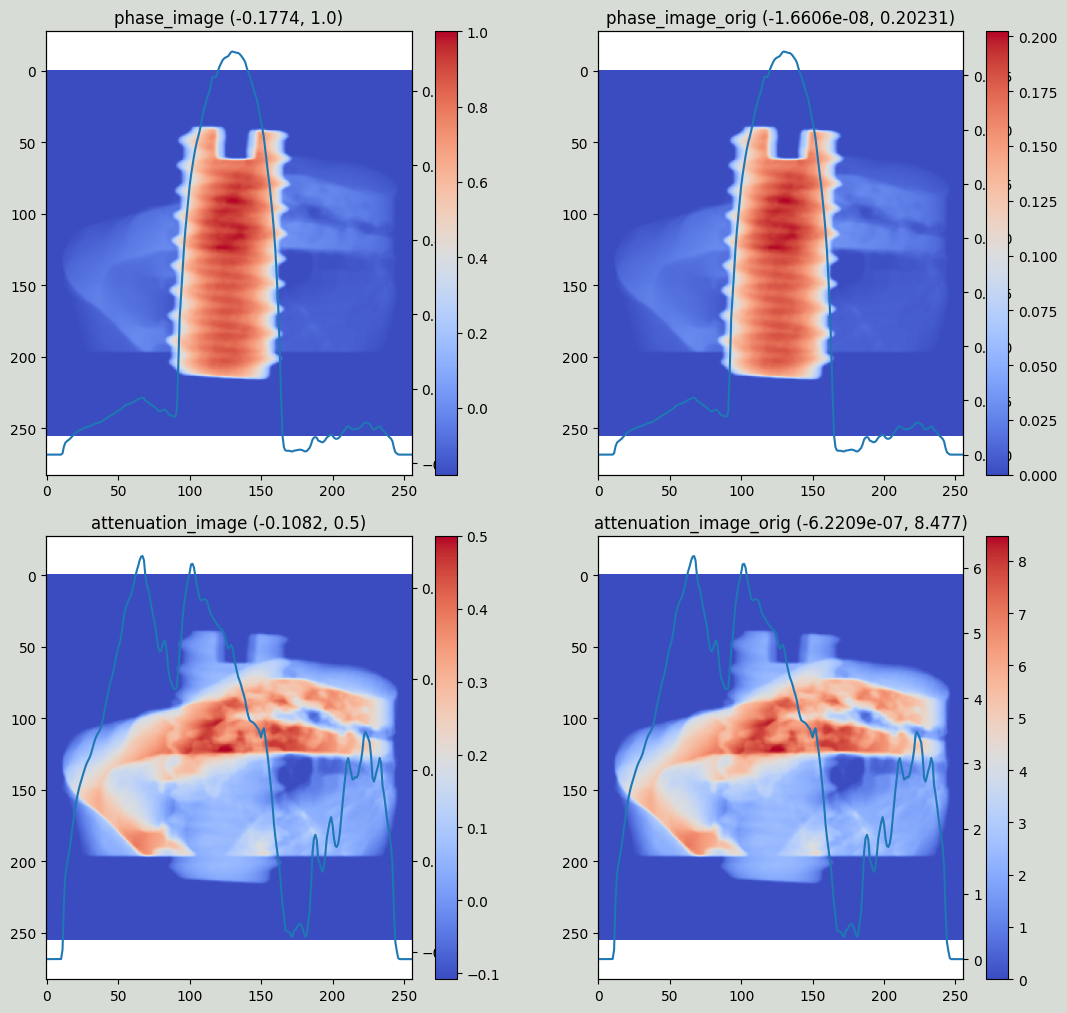

In [7]:
def get_from_sim(phase, attenuation, energy=None, z=None, fresnel_number=None, pv=None, abs_ratio=0.5):
    import quantities as pq
    energy = pq.Quantity(energy, 'keV') if energy is not None else None
    z = pq.Quantity(z, 'm') if z is not None else None
    pv = pq.Quantity(pv, 'm') if pv is not None else None
    fresnel_number = pq.Quantity(fresnel_number, 'dimensionless') if fresnel_number is not None else None

    if energy is None or z is None or pv is None:
        assert fresnel_number is not None        
        if energy == None and [z, pv] != None:
            lam = pv**2 / (fresnel_number * z)
            energy = energy_from_wavelength(lam)
            energy = energy.rescale('keV')
        elif z == None and [energy, pv] != None:
            lam = wavelength_from_energy(energy)
            z = pv**2 / (fresnel_number * lam)
            print('z: ', z, 'pv: ', pv, 'lam: ', lam)
        elif pv == None and [energy, z] != None:
            lam = wavelength_from_energy(energy)
            pv = np.sqrt(fresnel_number * z * lam)
            pv = pq.Quantity(pv, 'm')
        else:
            raise ValueError('Not enough information provided')
    else:
        lam = wavelength_from_energy(energy)
        fresnel = pv**2 / (lam * z) * pq.Quantity(1, 'dimensionless')

        if fresnel_number is not None:
            if fresnel_number == fresnel:
                pass
            else:
                print('Warning: Fresnel number does not match with the other parameters')
                fresnel_number = fresnel
        else:
            fresnel_number = fresnel
    phase_image_orig = phase * 2 * np.pi / lam.magnitude
    attenuation_image_orig = attenuation * 2*np.pi / lam.magnitude
    phase_image = nor_phase(phase_image_orig)/np.max(nor_phase(phase_image_orig))
    attenuation_image = (nor_phase(attenuation_image_orig)/np.max(nor_phase(attenuation_image_orig))) * abs_ratio

    print('energy: ', energy, 'z: ', z, 'fresnel_number: ', fresnel_number, 'pv: ', pv, 'lam: ', lam)
    return phase_image_orig, attenuation_image_orig, phase_image, attenuation_image, energy.magnitude, z.magnitude, fresnel_number.magnitude, pv.magnitude, lam.magnitude

phase_image_orig, attenuation_image_orig, phase_image, attenuation_image, energy, z, fresnel_number, pv, lam = get_from_sim(phase_image_resized, attenuation_image_resized, energy=60, pv=None, z = 19.8219, fresnel_number=0.01)
print('energy: ', energy, 'z: ', z, 'fresnel_number: ', fresnel_number, 'pv: ', pv, 'lam: ', lam)

geometry = {
    'phase': phase_image,
    'attenuation': attenuation_image,
    'energy_kev': energy,
    'z': z,
    'pv': pv,
    'fresnel_number': fresnel_number,
    'lam': lam
}
f = visualize([phase_image, phase_image_orig, attenuation_image, attenuation_image_orig], show_or_plot='both', title=['phase_image', 'phase_image_orig', 'attenuation_image', 'attenuation_image_orig'], rows=2, cols=2)

1 (128, 128)
rows:  1 cols:  1


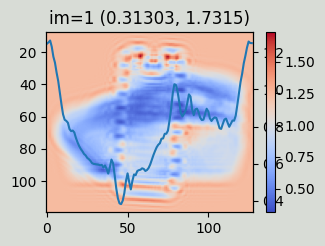

In [8]:
spider_hair_images = io.imread('data/gan_phase/data_spider.tif')
spider_hair = {
    'path': spider_hair_images,
    'experiment_name': 'spider_hair',
    'energy_kev': 11,
    'pv': 1.04735263e-7,
    'z': 7.8880960e-2,
    'idx': [120],
}

spider_hair_best = {
    'path': spider_hair_images,
    'experiment_name': 'spider_hair',
    'energy_kev': 11.2999999,
    'pv': 1.04735263e-7,
    'z': 7.8880960e-2,
    'idx': [120],

}

samis_mouse_images= io.imread('/asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/2023-11-03_17-32-56_flatfield_corrected.tiff')
# samis_mouse_images = io.imread_collection('/asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111233_sf04_1p2p1_OV_JD/logs/nano111233_sf04_1p2p1_OV_reco_single/*.tiff')
sami_mouse_good = {
    'path':  samis_mouse_images,
    'idx': [0],#[201, 234, 275, 326, 355, 388, 431, 482, 533, 584, 635, 680, 725, 776],
    'experiment_name': 'sami_mouse',
    'energy_kev': 11.0,
    'pv': 2.820144109415012e-06,
    'z': 1.9191507469051687,
}

sami_best_distance = {
    'path':  samis_mouse_images,
    'idx': [0], #[201, 234, 275, 326, 355, 388, 431, 482, 533, 584, 635, 680, 725, 776],
    'experiment_name': 'sami_mouse',
    'energy_kev': 11.0,
    'pv': 2.820144109415012e-06,
    'z': 1.90664,
    'abs_ratio': 0.039,
    'iter_num': 100,
    'abs_ratio': 0.00078,
}

sami_farther = {
    'path': samis_mouse_images,
    'idx': [0], #[201, 234, 275, 326, 355, 388, 431, 482, 533, 584, 635, 680, 725, 776],
    'experiment_name': 'sami_mouse',
    'energy_kev': 11.0,
    'pv': 2.820144109415012e-06,
    'z': 1.95,
}

sami_closer = {
    'path':  samis_mouse_images,
    'idx': [0],
    'experiment_name': 'sami_mouse',
    'energy_kev': 11.0,
    'pv': 2.820144109415012e-06,
    'z': 1.9,
}   

sami_spider_image = io.imread('/asap3/petra3/gpfs/p05/2023/data/11017690/processed/nano111200_spiderh_750/logs/nano111200_spiderh_750_reco_single/2023-10-27_16-25-04_flatfield_corrected.tiff')
info_sami_spider = {
    'path': sami_spider_image,
    'experiment_name': 'sami_spider',
    'energy_kev': 11.0,
    'pv': 9.193699824924853e-08,
    'z': 0.2769425256194748 #0.0010809961997837324,
}

ratio = {'l1_ratio': 10, 'contrast_ratio': 0, 'normalized_ratio': 5, 'brightness_ratio': 0, 'contrast_normalize_ratio': 0, 'brightness_normalize_ratio': 0, 'l2_ratio': 0, 'fourier_ratio': 1}

info = {
    'downsampling_factor': 2,
    'pad':2,
    'transform_factor': 0.1,
    'transform_type': 'reshape',
    'mode': 'reflect',
    'value': 'min',
    'device': 'cuda:0',
    'iter_num': 1000,
    'abs_ratio': 0.01,
    'possible_distance_gap': 0,
    'number_of_distances': 0,
}
info.update(geometry)
dataloader = Ganrec_Dataloader(**info)
f = dataloader.visualize(show_or_plot='both')
model = make_ganrec_model(**dataloader.kwargs)


In [18]:
info.update(geometry)
dataloader = Ganrec_Dataloader(**info)
condition = 'distance_sample_detector' 
value = dataloader.kwargs[condition]

model = make_ganrec_model(**dataloader.kwargs)
values = get_list_of_possibilities(value= dataloader.kwargs[condition], gap = None, number_of_elements = 10)
print(value, values)

time_start = time.time()
x = model.refine_parameters_using_condition(condition, values, change_from_soure=True, info = info, ratio = ratio)
# using concurrent.futures
# import concurrent.futures
# x = []
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     for i in range(len(values)):
#         x.append(executor.submit(model.refine_parameters_using_condition, condition, values[i], change_from_soure=True, info = info, ratio = ratio))


time_end = time.time()
print(time_end - time_start, " seconds")

# import joblib
# from joblib import Parallel, delayed

# 
# x = Parallel(n_jobs=len(values))(delayed(model.refine_parameters_using_condition)(condition, values[i], change_from_soure=True, info = info, ratio = ratio) for i in range(len(values)))
# time_end = time.time()
# print(time_end - time_start, " seconds")

1 (128, 128)
19.8219 [9.91095, 11.893139999999999, 13.875329999999998, 15.85752, 17.83971, array(19.8219), 21.80409, 23.786279999999998, 25.76847, 27.75066, 29.73285]
1 (128, 128)


RuntimeError: Padding size should be less than the corresponding input dimension, but got: padding (192, 192) at dimension 3 of input [1, 1, 128, 128]

In [13]:
model.transformed_images.shape

torch.Size([1, 1, 128, 128])

In [ ]:
condition = 'abs_ratio'
value = dataloader.kwargs[condition]

model = make_ganrec_model(**dataloader.kwargs)
values = get_list_of_possibilities(value= dataloader.kwargs[condition], gap = None, number_of_elements = 10)

print(value, values)

time_start = time.time()    
x1 = [model.refine_parameters_using_condition(condition, values[i], change_from_soure=True, info = info, ratio = ratio) for i in range(len(values))]
time_end = time.time()
print(time_end - time_start, " seconds")


In [ ]:
df_all1 = pd.concat([x1[i][0] for i in range(len(x1))])
plot_pandas(df_all1, ['main_diff', 'gen_loss', 'dis_loss'], x_column = condition)

In [ ]:
# plot_pandas(x[0][0], ['main_diff', 'gen_loss', 'dis_loss'], x_column = condition)
df_all = pd.concat([x[i][0] for i in range(len(x))])
plot_pandas(df_all, ['main_diff', 'gen_loss', 'dis_loss'], x_column = condition)

In [ ]:
images = ((x[i][3][j] for j in range(len(x[i][3]))) for i in range(len(x)))

In [ ]:
images(0)